In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import time
import Generator
import Discriminator

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# loading dataset from file
dataset_real = glob.glob("/home/ragavendrankk/celebA_ds/*")
dataset_comic = glob.glob("/home/ragavendrankk/facemaker_ds/*")

# Count of dataset
dataset_real_count = 30000
dataset_comic_count = 26020

# Training count
dataset_real_training_count = int(dataset_real_count * 0.8)
dataset_comic_training_count = int(dataset_comic_count * 0.8)

# Split training and test dataset
train_comic, train_real = tf.data.Dataset.from_tensor_slices(dataset_comic[0:dataset_comic_training_count]), tf.data.Dataset.from_tensor_slices(dataset_real[0:dataset_real_training_count])
test_comic, test_real = tf.data.Dataset.from_tensor_slices(dataset_comic[dataset_comic_training_count:dataset_comic_count]), tf.data.Dataset.from_tensor_slices(dataset_real[dataset_real_training_count:dataset_real_count])

BUFFER_SIZE = 1000
BATCH_SIZE = 64
IMG_WIDTH = 64
IMG_HEIGHT = 64

In [3]:
def train_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = ((image / 127.5) - 1)

    # resizing to 72 x 72 x 3
    image = tf.image.resize(image, [72, 72],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 64 x 64 x 3
    image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [4]:
def test_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = ((image / 127.5) - 1)
    
    # resizing to 64 x 64 x 3
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image

In [5]:
train_comic = train_comic.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_real = train_real.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_comic = test_comic.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_real = test_real.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

print("Done Pre processing")

Done Pre processing


In [6]:
# Model creation
generator = Generator.create_generator()
discriminator = Discriminator.create_discriminator()

In [7]:
# Sample image from data set
sample_comic = next(iter(train_comic))
sample_real = next(iter(train_real))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


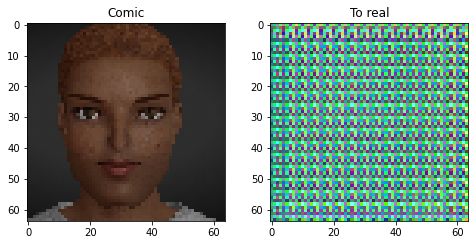

In [8]:
# Generating real image before training
to_real = generator(sample_comic)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_comic, to_real]
title = ['Comic', 'To real']

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [9]:
LAMBDA = 10

In [10]:
# Binary cross entropy loss object
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
# Generator and Discriminator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def identity_loss(real, generated):
    loss = tf.reduce_mean(tf.abs(real - generated))
    return LAMBDA * 0.5 * loss

In [12]:
# Optimizer for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [14]:
EPOCHS = 40

In [15]:
# generating image during training and printing
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

In [16]:
@tf.function
def train_step(real_x, real_y, epoch):

    with tf.GradientTape(persistent=True) as tape:
        # Generator translates X -> Y

        fake_y = generator(real_x, training=True)

        disc_real_y = discriminator(real_y, training=True)
        disc_fake_y = discriminator(fake_y, training=True)      

        # calculate the loss
        gen_loss = generator_loss(disc_fake_y) + identity_loss(real_x, fake_y)
        disc_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_gradients = tape.gradient(gen_loss,
                                          generator.trainable_variables)

    discriminator_gradients = tape.gradient(disc_loss,
                                              discriminator.trainable_variables)

    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

.................................

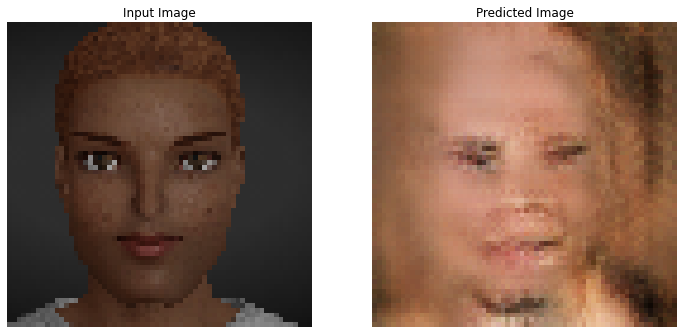

Time taken for epoch 1 is 248.43900680541992 sec

.................................

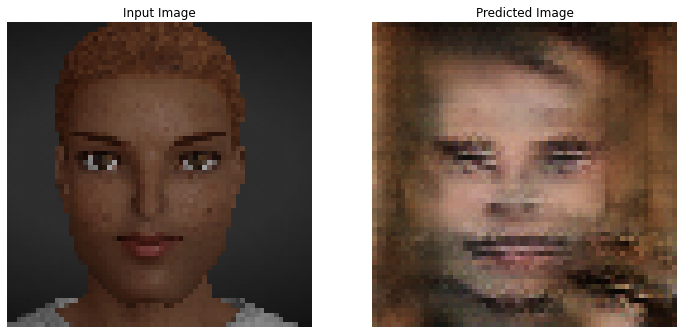

Time taken for epoch 2 is 226.0857129096985 sec

.................................

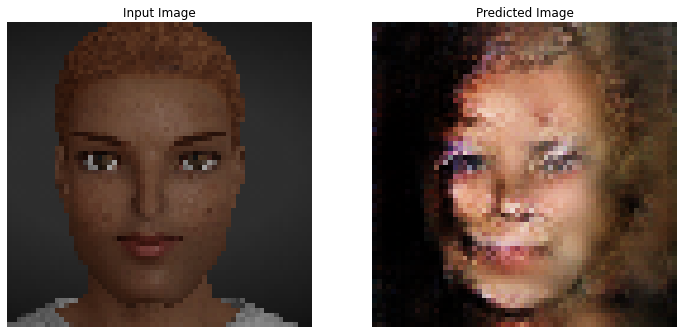

Time taken for epoch 3 is 226.93038892745972 sec

.................................

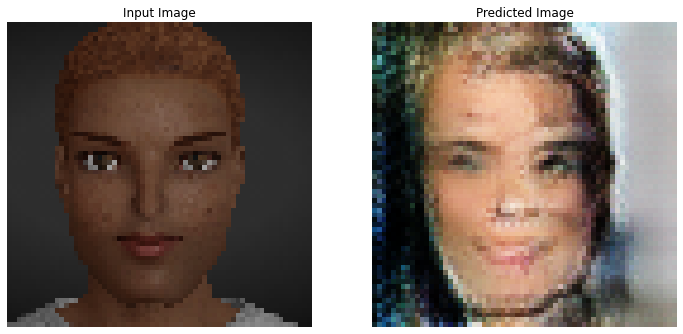

Time taken for epoch 4 is 225.4326138496399 sec

.................................

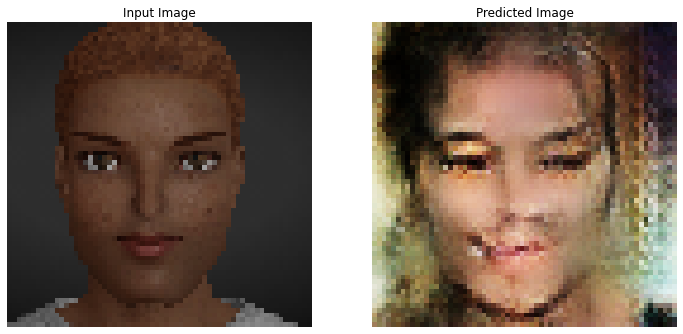

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-3
Time taken for epoch 5 is 229.2478380203247 sec

.................................

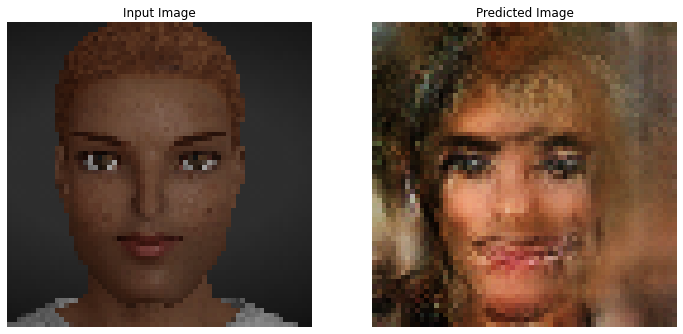

Time taken for epoch 6 is 223.93192553520203 sec

.................................

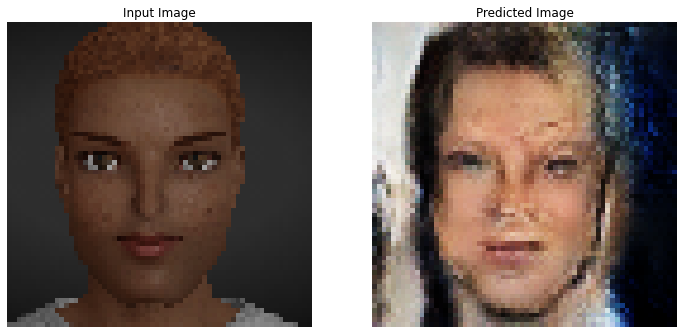

Time taken for epoch 7 is 225.15536069869995 sec

.................................

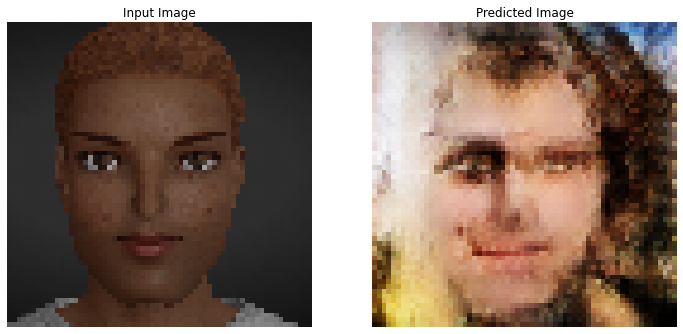

Time taken for epoch 8 is 222.23910546302795 sec

.................................

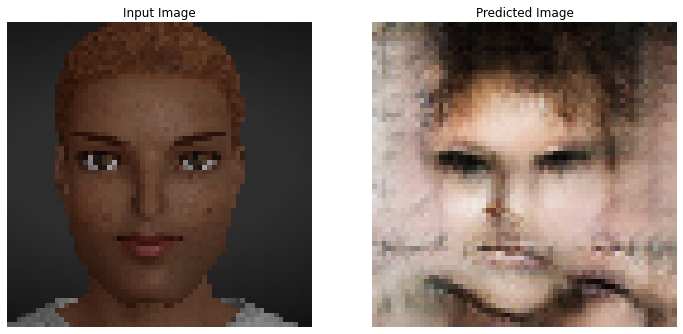

Time taken for epoch 9 is 220.22795367240906 sec

.................................

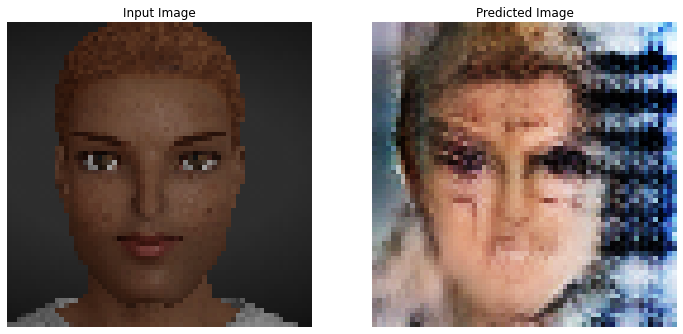

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-4
Time taken for epoch 10 is 226.07890486717224 sec

.................................

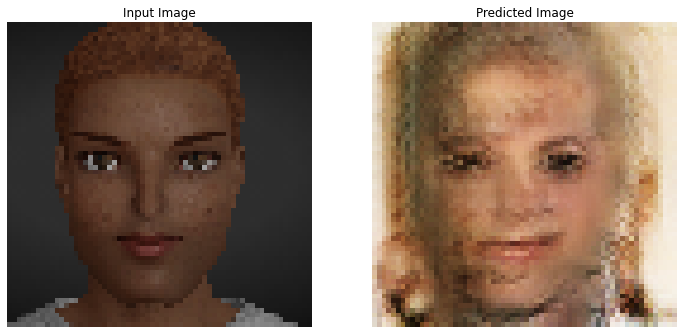

Time taken for epoch 11 is 222.9667456150055 sec

.................................

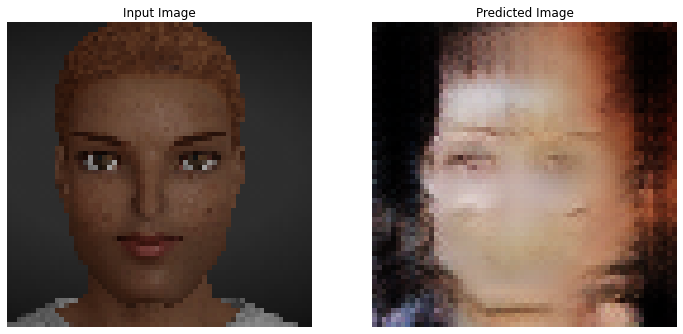

Time taken for epoch 12 is 223.16494870185852 sec

.................................

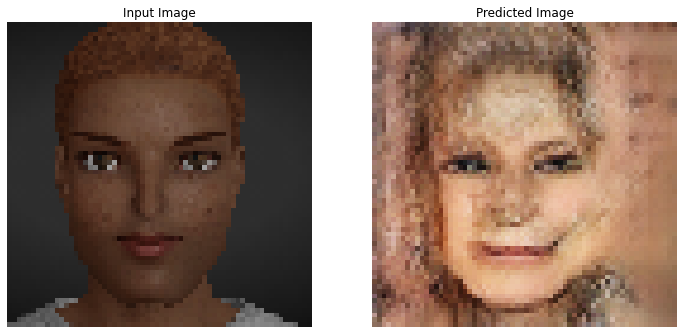

Time taken for epoch 13 is 226.60909795761108 sec

.................................

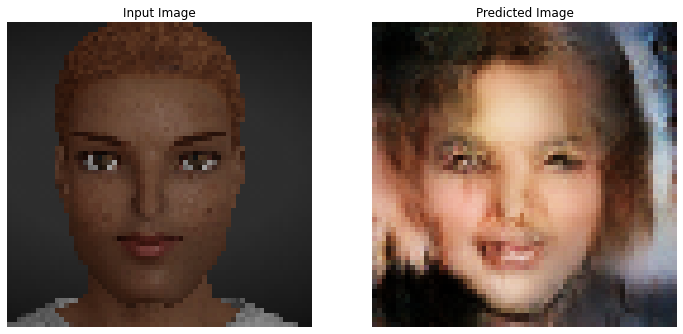

Time taken for epoch 14 is 226.2549958229065 sec

.................................

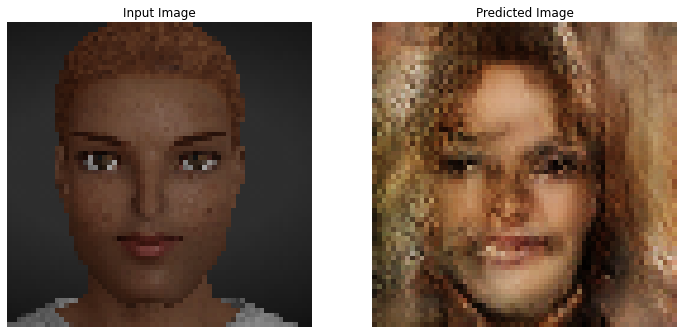

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-5
Time taken for epoch 15 is 228.25449395179749 sec

.................................

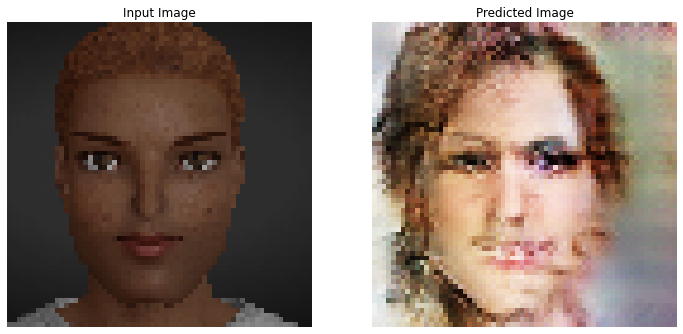

Time taken for epoch 16 is 225.70985341072083 sec

.................................

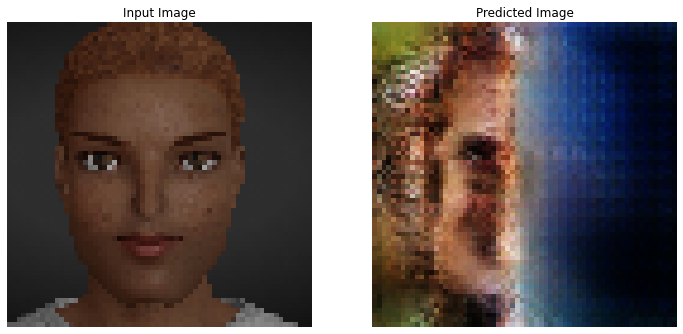

Time taken for epoch 17 is 226.44499850273132 sec

.................................

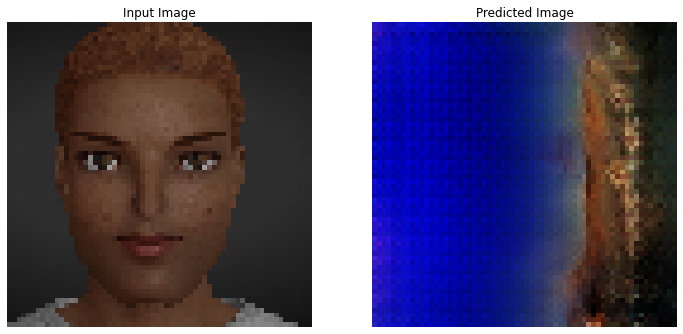

Time taken for epoch 18 is 222.80145454406738 sec

.................................

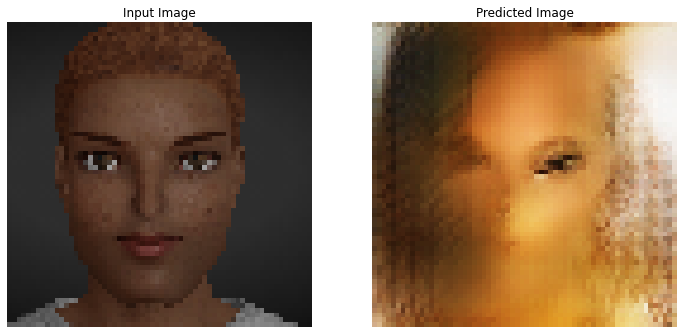

Time taken for epoch 19 is 218.14896726608276 sec

.................................

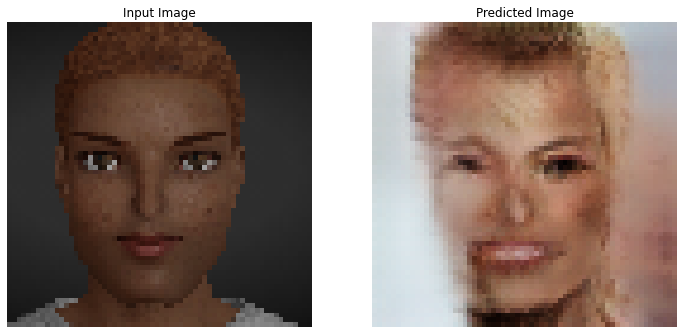

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-6
Time taken for epoch 20 is 217.77097249031067 sec

.................................

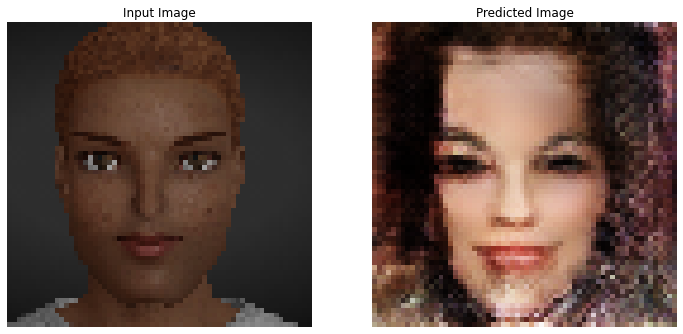

Time taken for epoch 21 is 228.56823062896729 sec

.................................

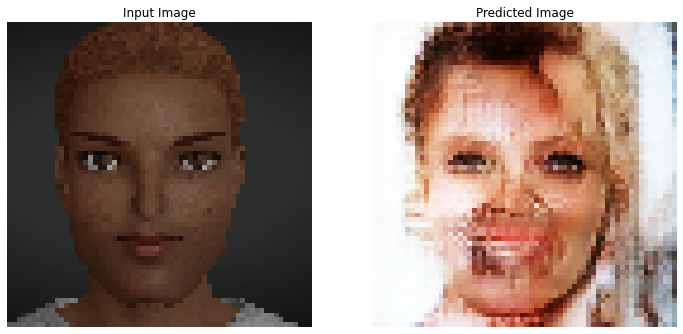

Time taken for epoch 22 is 220.78200125694275 sec

.................................

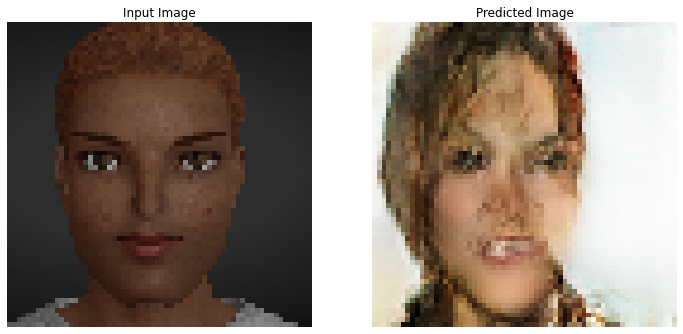

Time taken for epoch 23 is 219.72256326675415 sec

.................................

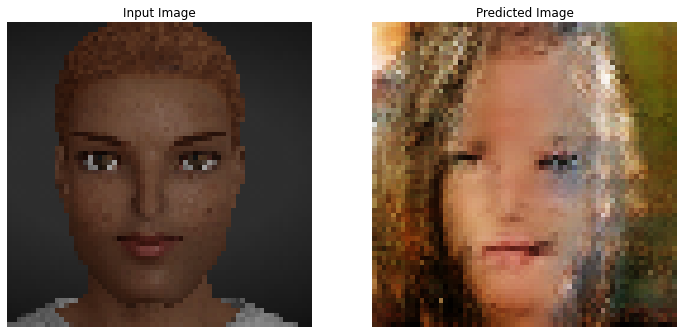

Time taken for epoch 24 is 224.27719616889954 sec

.................................

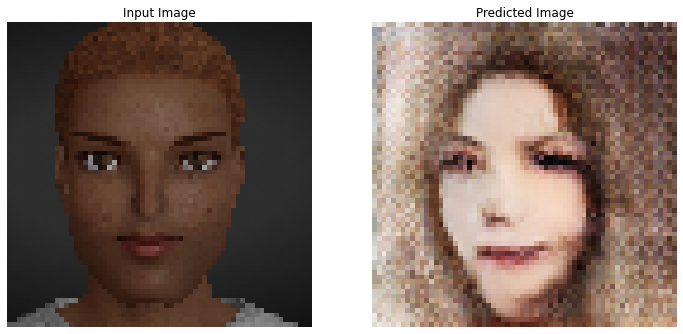

Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-7
Time taken for epoch 25 is 219.82784366607666 sec

.................................

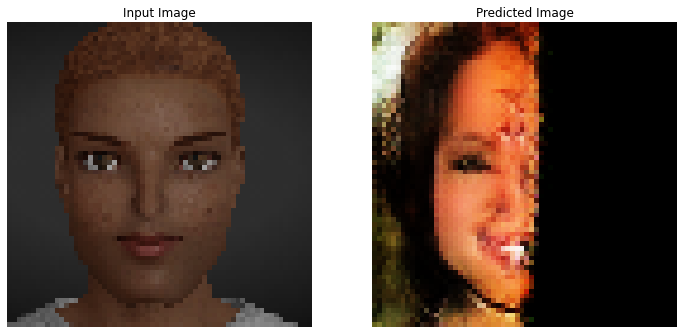

Time taken for epoch 26 is 223.75128626823425 sec

.................................

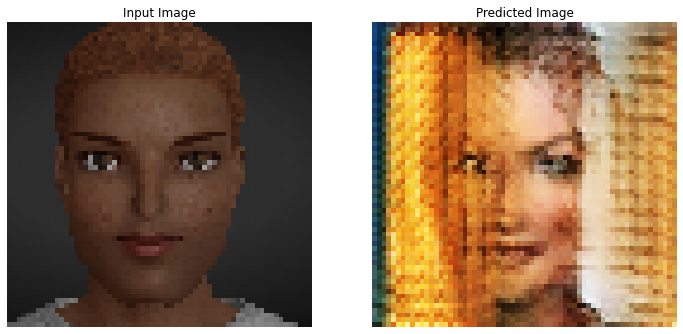

Time taken for epoch 27 is 223.266361951828 sec

.................................

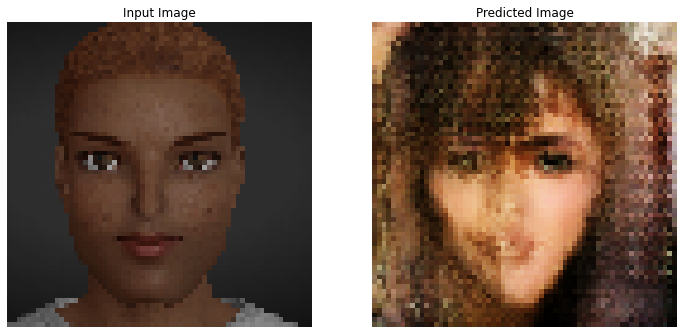

Time taken for epoch 28 is 220.7235610485077 sec

.................................

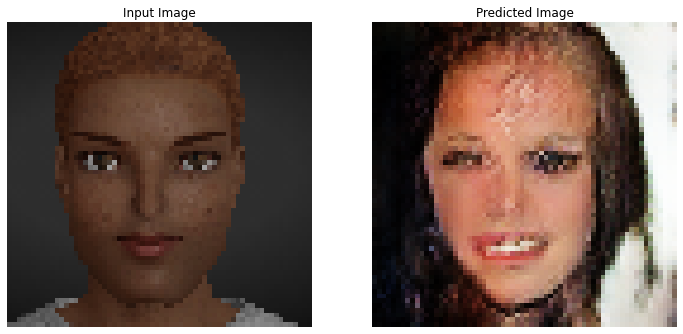

Time taken for epoch 29 is 217.1227834224701 sec

.................................

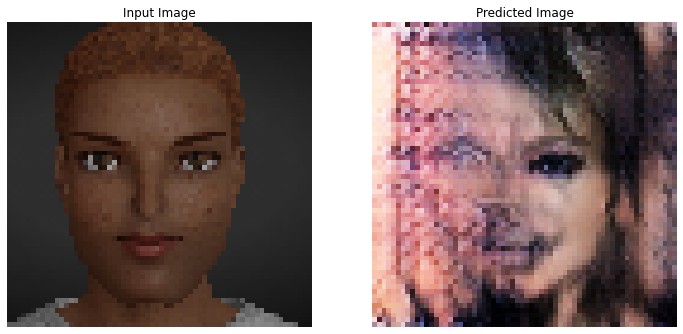

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-8
Time taken for epoch 30 is 219.7017183303833 sec

.................................

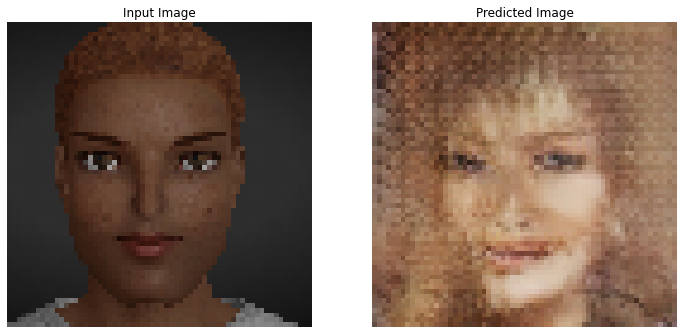

Time taken for epoch 31 is 223.31783175468445 sec

.................................

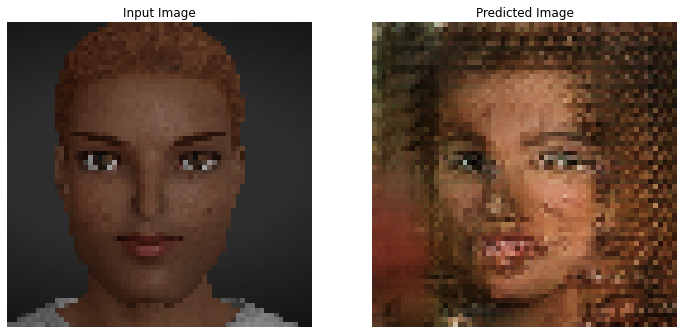

Time taken for epoch 32 is 224.39002966880798 sec

.................................

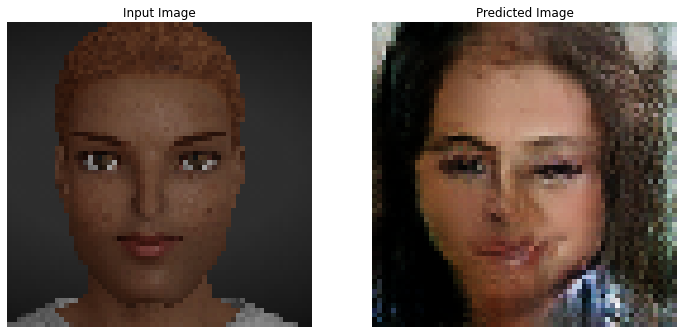

Time taken for epoch 33 is 222.01637816429138 sec

.................................

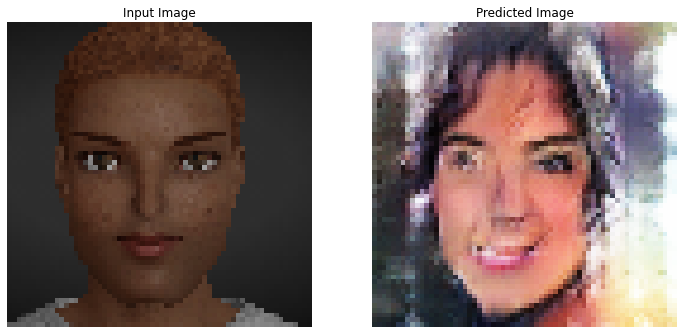

Time taken for epoch 34 is 223.1097252368927 sec

.................................

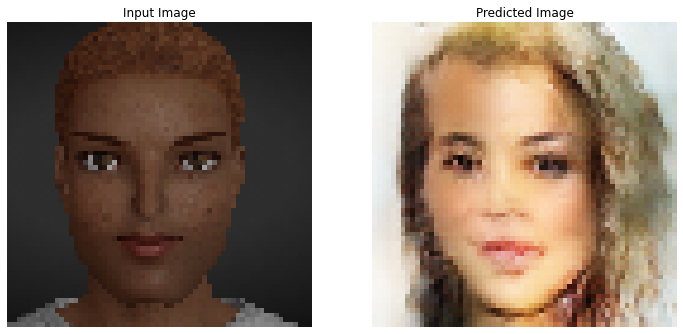

Saving checkpoint for epoch 35 at ./checkpoints/train/ckpt-9
Time taken for epoch 35 is 221.89237999916077 sec

.................................

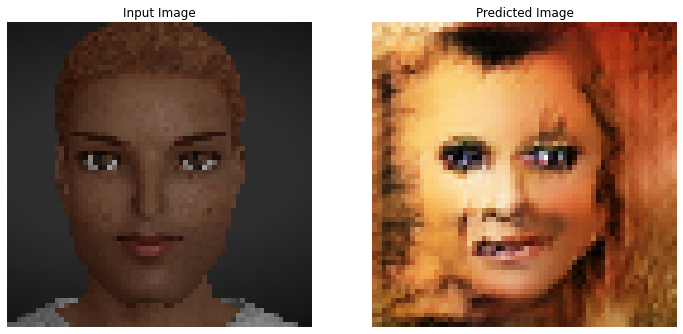

Time taken for epoch 36 is 223.58507251739502 sec

.................................

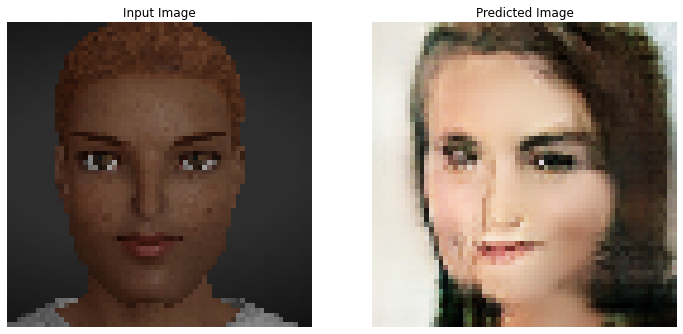

Time taken for epoch 37 is 221.22926473617554 sec

.................................

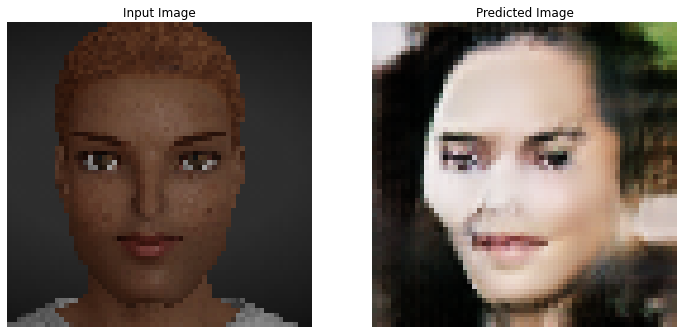

Time taken for epoch 38 is 224.52863121032715 sec

.................................

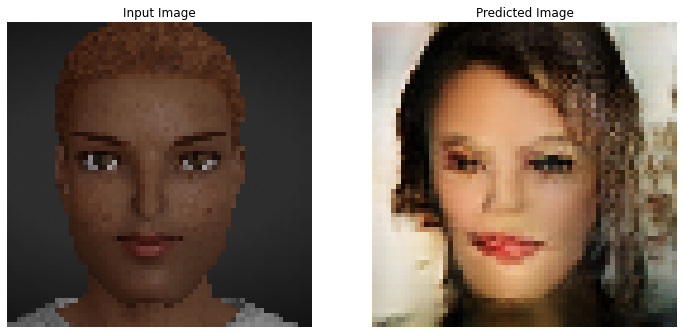

Time taken for epoch 39 is 221.37645816802979 sec

.................................

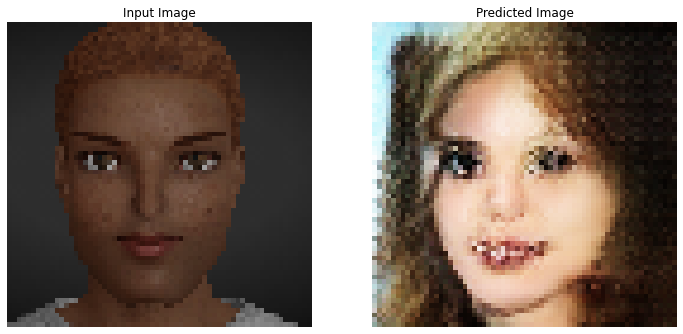

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-10
Time taken for epoch 40 is 220.45268177986145 sec



In [17]:
# Training
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_comic, train_real)):
        train_step(image_x, image_y, epoch)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    generate_images(generator, sample_comic)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                       time.time() - start))

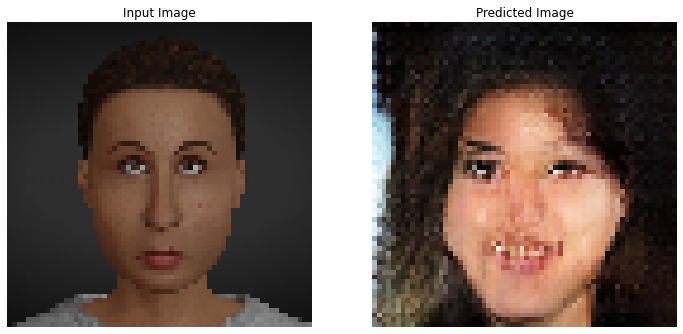

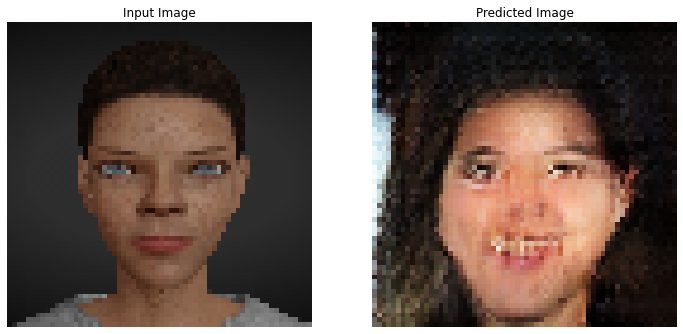

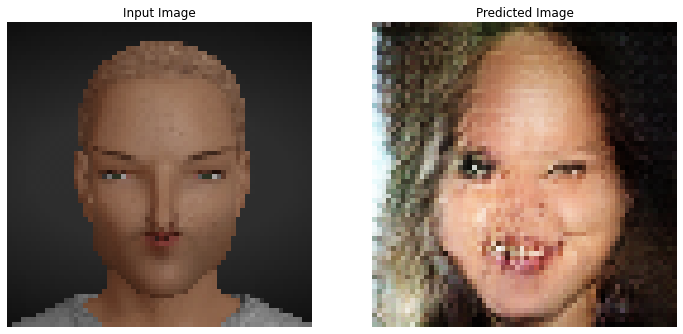

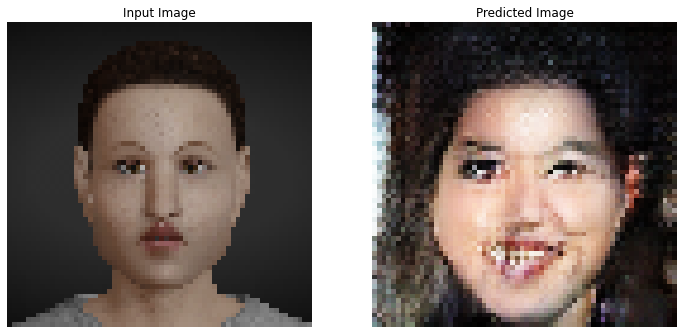

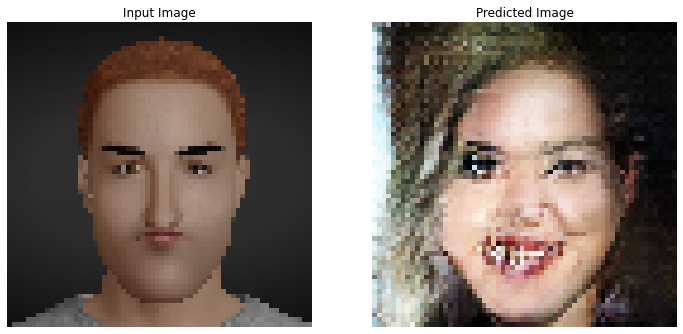

In [18]:
# Testing
for i in range(5):
    generate_images(generator, next(iter(test_comic)))